# 🧠 Part 2: CNN with Batch Normalization
## SimpleCNN + BatchNorm - שיפור ביציבות ומהירות הלמידה!

---

### 🎯 מה זה Batch Normalization?
טכניקה שמנרמלת את הפלט של כל שכבה:
- **מייצבת את הלמידה** - מונעת gradient vanishing/exploding
- **מאפשרת learning rate גבוה יותר** - התכנסות מהירה יותר!
- **פועלת כ-regularization** - מפחיתה overfitting
- **פחות תלות ב-initialization** - פחות רגיש למשקלים ההתחלתיים

### ✨ שיפורים בנוטבוק הזה:
1. **BatchNorm אחרי כל Conv layer** - נורמליזציה של feature maps
2. **Weight Decay חזק יותר** - 5e-4 במקום 1e-4
3. **Cosine Annealing LR Scheduler** - ירידה חלקה של learning rate
4. **אותה ארכיטקטורה כמו 02** - כדי להשוות בצורה הוגנת!

### 📊 תוצאות צפויות:
- 🎯 Validation Accuracy: **72-75%** (שיפור של 2-5%!)
- 📉 Overfitting Gap: **<2%** (פחות מ-02!)
- ⏱️ זמן אימון: דומה או מעט יותר ארוך
- 🚀 התכנסות מהירה יותר בתחילת האימון

## 1️⃣ ייבוא ספריות

In [4]:
import os
import sys
from pathlib import Path
import json
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

sys.path.append(str(Path.cwd().parent / 'src'))
import config

print("✅ All libraries imported!")
print(f"🖥️  Device: {config.DEVICE}")
print(f"📦 Batch size: {config.BATCH_SIZE}")
print(f"📈 Learning rate: {config.LEARNING_RATE}")
print(f"🔢 Max Epochs: {config.NUM_EPOCHS}")
print(f"⏸️  Early Stopping Patience: {config.PATIENCE}")

✅ All libraries imported!
🖥️  Device: cpu
📦 Batch size: 32
📈 Learning rate: 0.001
🔢 Max Epochs: 25
⏸️  Early Stopping Patience: 5


## 2️⃣ טעינת Dataset Splits

In [2]:
splits_path = config.RESULTS_DIR / 'dataset_splits.json'

with open(splits_path, 'r') as f:
    splits_data = json.load(f)

train_indices = splits_data['train_indices']
val_indices = splits_data['val_indices']
test_indices = splits_data['test_indices']
class_names = splits_data['class_names']
num_classes = splits_data['num_classes']

print("✅ Splits loaded!")
print(f"📊 Train: {len(train_indices)}, Val: {len(val_indices)}, Test: {len(test_indices)}")

✅ Splits loaded!
📊 Train: 1466, Val: 314, Test: 315


## 3️⃣ יצירת DataLoaders

In [6]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE + 32, config.IMAGE_SIZE + 32)),
    transforms.RandomCrop((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

val_test_transforms = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

data_path = config.DATA_PATH

train_dataset_full = ImageFolder(root=str(data_path), transform=train_transforms)
train_dataset = Subset(train_dataset_full, train_indices)

val_dataset_full = ImageFolder(root=str(data_path), transform=val_test_transforms)
val_dataset = Subset(val_dataset_full, val_indices)

train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    num_workers=0,  # 0 for simplicity on Windows
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=0,  # 0 for simplicity on Windows
    pin_memory=False
)

print(f"✅ DataLoaders created!")
print(f"📊 Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

✅ DataLoaders created!
📊 Train batches: 46, Val batches: 10


## 4️⃣ בניית המודל: SimpleCNN + BatchNorm

### 🔬 הסבר על Batch Normalization:

```python
# לפני BatchNorm:
Conv → ReLU → MaxPool

# אחרי BatchNorm:
Conv → BatchNorm → ReLU → MaxPool
```

**מה קורה בכל batch:**
1. **Normalization**: $\hat{x} = \frac{x - \mu_{batch}}{\sqrt{\sigma_{batch}^2 + \epsilon}}$
2. **Scale & Shift**: $y = \gamma \hat{x} + \beta$ (פרמטרים לומדים!)

**למה זה עוזר?**
- 🎯 כל שכבה מקבלת input מנורמל → למידה יציבה
- 🚀 אפשר learning rate גבוה יותר → התכנסות מהירה
- 📉 פועל כ-regularization קל → פחות overfitting
- 💪 פחות רגיש ל-weight initialization

In [19]:
class SimpleCNN_BatchNorm(nn.Module):
    """SimpleCNN with Batch Normalization after each conv layer"""
    
    def __init__(self, num_classes=4):
        super(SimpleCNN_BatchNorm, self).__init__()
        
        # Conv Block 1: 3 → 16 channels
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)  # ✨ BatchNorm for 16 channels
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Conv Block 2: 16 → 32 channels
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)  # ✨ BatchNorm for 32 channels
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Conv Block 3: 32 → 64 channels
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)  # ✨ BatchNorm for 64 channels
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Calculate flattened size: 224 → 112 → 56 → 28
        # 28 * 28 * 64 = 50,176
        self.flatten_size = 28 * 28 * 64
        
        # Fully Connected Layers with Dropout (OPTIMAL: 0.5/0.4)
        self.fc1 = nn.Linear(self.flatten_size, 256)
        self.dropout1 = nn.Dropout(0.5)  # ✨ Optimal with BatchNorm
        
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.4)  # ✨ Balanced regularization
        
        self.fc3 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        # Conv Block 1: Conv → BatchNorm → ReLU → MaxPool
        x = self.conv1(x)
        x = self.bn1(x)      # ✨ Normalize after conv
        x = self.relu1(x)
        x = self.pool1(x)
        
        # Conv Block 2: Conv → BatchNorm → ReLU → MaxPool
        x = self.conv2(x)
        x = self.bn2(x)      # ✨ Normalize after conv
        x = self.relu2(x)
        x = self.pool2(x)
        
        # Conv Block 3: Conv → BatchNorm → ReLU → MaxPool
        x = self.conv3(x)
        x = self.bn3(x)      # ✨ Normalize after conv
        x = self.relu3(x)
        x = self.pool3(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # FC Layers
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = nn.ReLU()(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        
        return x

# Create model
model = SimpleCNN_BatchNorm(num_classes=num_classes).to(config.DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("✅ SimpleCNN_BatchNorm created! (v3 - OPTIMIZED VERSION)")
print(f"📊 Total parameters: {total_params:,}")
print(f"🎯 Trainable parameters: {trainable_params:,}")
print(f"🔧 Dropout rates: 0.5 / 0.4 (optimal!)")
print(f"\n🏗️  Model Architecture:")
print(model)

✅ SimpleCNN_BatchNorm created! (v3 - OPTIMIZED VERSION)
📊 Total parameters: 12,902,532
🎯 Trainable parameters: 12,902,532
🔧 Dropout rates: 0.5 / 0.4 (optimal!)

🏗️  Model Architecture:
SimpleCNN_BatchNorm(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ce

## 5️⃣ הגדרת Loss, Optimizer, Scheduler

### 🔧 שיפורים:
1. **Weight Decay גבוה יותר** (5e-4): BatchNorm מאפשר regularization חזק יותר
2. **Cosine Annealing LR Scheduler**: ירידה חלקה של learning rate
   - מתחיל ב-0.001
   - יורד בצורה חלקה ל-0 (cosine curve)
   - עוזר להתכנסות טובה יותר!

In [20]:
criterion = nn.CrossEntropyLoss()

# Adam optimizer with optimal weight decay
optimizer = optim.Adam(
    model.parameters(),
    lr=config.LEARNING_RATE,
    weight_decay=1e-4  # Same as notebook 02
)

# StepLR Scheduler (same as notebook 02 - proven to work!)
scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=10,  # Reduce LR every 10 epochs
    gamma=0.5      # Multiply LR by 0.5
)

print("✅ Loss, Optimizer, Scheduler ready! (v3 - OPTIMIZED VERSION)")
print(f"📉 Loss: CrossEntropyLoss")
print(f"🎯 Optimizer: Adam (lr={config.LEARNING_RATE}, weight_decay=1e-4)")
print(f"📊 Scheduler: StepLR (step_size=10, gamma=0.5) - same as 02!")
print(f"🔧 Changes: StepLR instead of CosineAnnealing + Dropout 0.5/0.4")

✅ Loss, Optimizer, Scheduler ready! (v3 - OPTIMIZED VERSION)
📉 Loss: CrossEntropyLoss
🎯 Optimizer: Adam (lr=0.001, weight_decay=1e-4)
📊 Scheduler: StepLR (step_size=10, gamma=0.5) - same as 02!
🔧 Changes: StepLR instead of CosineAnnealing + Dropout 0.5/0.4


## 6️⃣ פונקציות אימון ואימות

In [9]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """Train model for one epoch"""
    model.train()  # Set BatchNorm to training mode!
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc="Training")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'acc': f"{100. * correct / total:.2f}%"
        })
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc


def validate(model, val_loader, criterion, device):
    """Validate model"""
    model.eval()  # Set BatchNorm to eval mode!
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc="Validation")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'acc': f"{100. * correct / total:.2f}%"
            })
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

print("✅ Training and validation functions ready!")

✅ Training and validation functions ready!


## 7️⃣ אימון המודל עם Early Stopping

### ⏸️ Early Stopping Logic:
- עוצר את האימון אם validation accuracy לא משתפר במשך `PATIENCE` epochs
- שומר את המודל הטוב ביותר אוטומטית
- חוסך זמן ומונע overfitting!

In [21]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

# Early stopping variables
best_val_acc = 0.0
patience_counter = 0
best_model_path = config.MODELS_DIR / 'simple_cnn_batchnorm_best_v3.pth'  # ✨ v3 - optimized!

print("🚀 Starting training... (v3 - OPTIMIZED VERSION)")
print("🔧 Changes: Dropout 0.5/0.4 + StepLR (like notebook 02)\n")
start_time = time.time()

for epoch in range(config.NUM_EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{config.NUM_EPOCHS}")
    print(f"{'='*60}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}\n")
    
    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, config.DEVICE)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, config.DEVICE)
    
    # Update scheduler
    scheduler.step()
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(optimizer.param_groups[0]['lr'])
    
    # Print epoch summary
    print(f"\n📊 Epoch {epoch+1} Summary:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ New best model saved! Val Acc: {val_acc:.2f}%")
    else:
        patience_counter += 1
        print(f"⏸️  No improvement. Patience: {patience_counter}/{config.PATIENCE}")
        
        if patience_counter >= config.PATIENCE:
            print(f"\n⛔ Early stopping triggered! No improvement for {config.PATIENCE} epochs.")
            break

total_time = time.time() - start_time
print(f"\n{'='*60}")
print(f"🎉 Training completed!")
print(f"⏱️  Total time: {total_time/60:.1f} minutes")
print(f"🏆 Best Val Accuracy: {best_val_acc:.2f}%")
print(f"{'='*60}")

🚀 Starting training... (v3 - OPTIMIZED VERSION)
🔧 Changes: Dropout 0.5/0.4 + StepLR (like notebook 02)


Epoch 1/25
Learning Rate: 0.001000



Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


📊 Epoch 1 Summary:
Train Loss: 2.5665, Train Acc: 30.29%
Val Loss: 1.2683, Val Acc: 37.58%
✅ New best model saved! Val Acc: 37.58%

Epoch 2/25
Learning Rate: 0.001000



Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


📊 Epoch 2 Summary:
Train Loss: 1.3167, Train Acc: 35.81%
Val Loss: 1.1925, Val Acc: 37.90%
✅ New best model saved! Val Acc: 37.90%

Epoch 3/25
Learning Rate: 0.001000



Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


📊 Epoch 3 Summary:
Train Loss: 1.2808, Train Acc: 39.36%
Val Loss: 1.1827, Val Acc: 50.96%
✅ New best model saved! Val Acc: 50.96%

Epoch 4/25
Learning Rate: 0.001000



Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


📊 Epoch 4 Summary:
Train Loss: 1.2190, Train Acc: 44.82%
Val Loss: 1.1354, Val Acc: 46.18%
⏸️  No improvement. Patience: 1/5

Epoch 5/25
Learning Rate: 0.001000



Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


📊 Epoch 5 Summary:
Train Loss: 1.2277, Train Acc: 45.02%
Val Loss: 1.2357, Val Acc: 40.13%
⏸️  No improvement. Patience: 2/5

Epoch 6/25
Learning Rate: 0.001000



Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


📊 Epoch 6 Summary:
Train Loss: 1.2166, Train Acc: 42.16%
Val Loss: 1.1226, Val Acc: 50.96%
⏸️  No improvement. Patience: 3/5

Epoch 7/25
Learning Rate: 0.001000



Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


📊 Epoch 7 Summary:
Train Loss: 1.2133, Train Acc: 42.22%
Val Loss: 1.2042, Val Acc: 41.72%
⏸️  No improvement. Patience: 4/5

Epoch 8/25
Learning Rate: 0.001000



Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


📊 Epoch 8 Summary:
Train Loss: 1.1989, Train Acc: 44.20%
Val Loss: 1.1854, Val Acc: 42.36%
⏸️  No improvement. Patience: 5/5

⛔ Early stopping triggered! No improvement for 5 epochs.

🎉 Training completed!
⏱️  Total time: 7.9 minutes
🏆 Best Val Accuracy: 50.96%


## 8️⃣ שמירת תוצאות ל-JSON

In [22]:
results = {
    'model_name': 'SimpleCNN_BatchNorm_v3',
    'version': 'v3 - Final attempt with StepLR',
    'total_params': total_params,
    'trainable_params': trainable_params,
    'num_epochs_trained': len(history['train_acc']),
    'best_val_accuracy': best_val_acc,
    'final_train_acc': history['train_acc'][-1],
    'final_val_acc': history['val_acc'][-1],
    'overfitting_gap': history['train_acc'][-1] - history['val_acc'][-1],
    'training_time_minutes': total_time / 60,
    'history': history,
    'hyperparameters': {
        'learning_rate': config.LEARNING_RATE,
        'batch_size': config.BATCH_SIZE,
        'weight_decay': 1e-4,
        'scheduler': 'StepLR',
        'scheduler_params': {'step_size': 10, 'gamma': 0.5},
        'dropout_rates': [0.5, 0.4],
        'early_stopping_patience': config.PATIENCE
    },
    'experiment_notes': {
        'goal': 'Improve over v2 by using StepLR (like notebook 02)',
        'result': 'Did not improve - BatchNorm may need even less regularization',
        'conclusion': 'BatchNorm did not improve results for this dataset/architecture'
    }
}

results_path = config.LOGS_DIR / 'simple_cnn_batchnorm_results_v3.json'
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"✅ Results v3 saved to: {results_path}")
print(f"🎯 Best Val Accuracy: {best_val_acc:.2f}%")
print(f"📝 Experiment documented for presentation")

✅ Results v3 saved to: c:\Users\Administrator\Desktop\Dan\Projects\waste-classifier-fastai\final_project\results\logs\simple_cnn_batchnorm_results_v3.json
🎯 Best Val Accuracy: 50.96%
📝 Experiment documented for presentation


## 9️⃣ ויזואליזציה של התוצאות

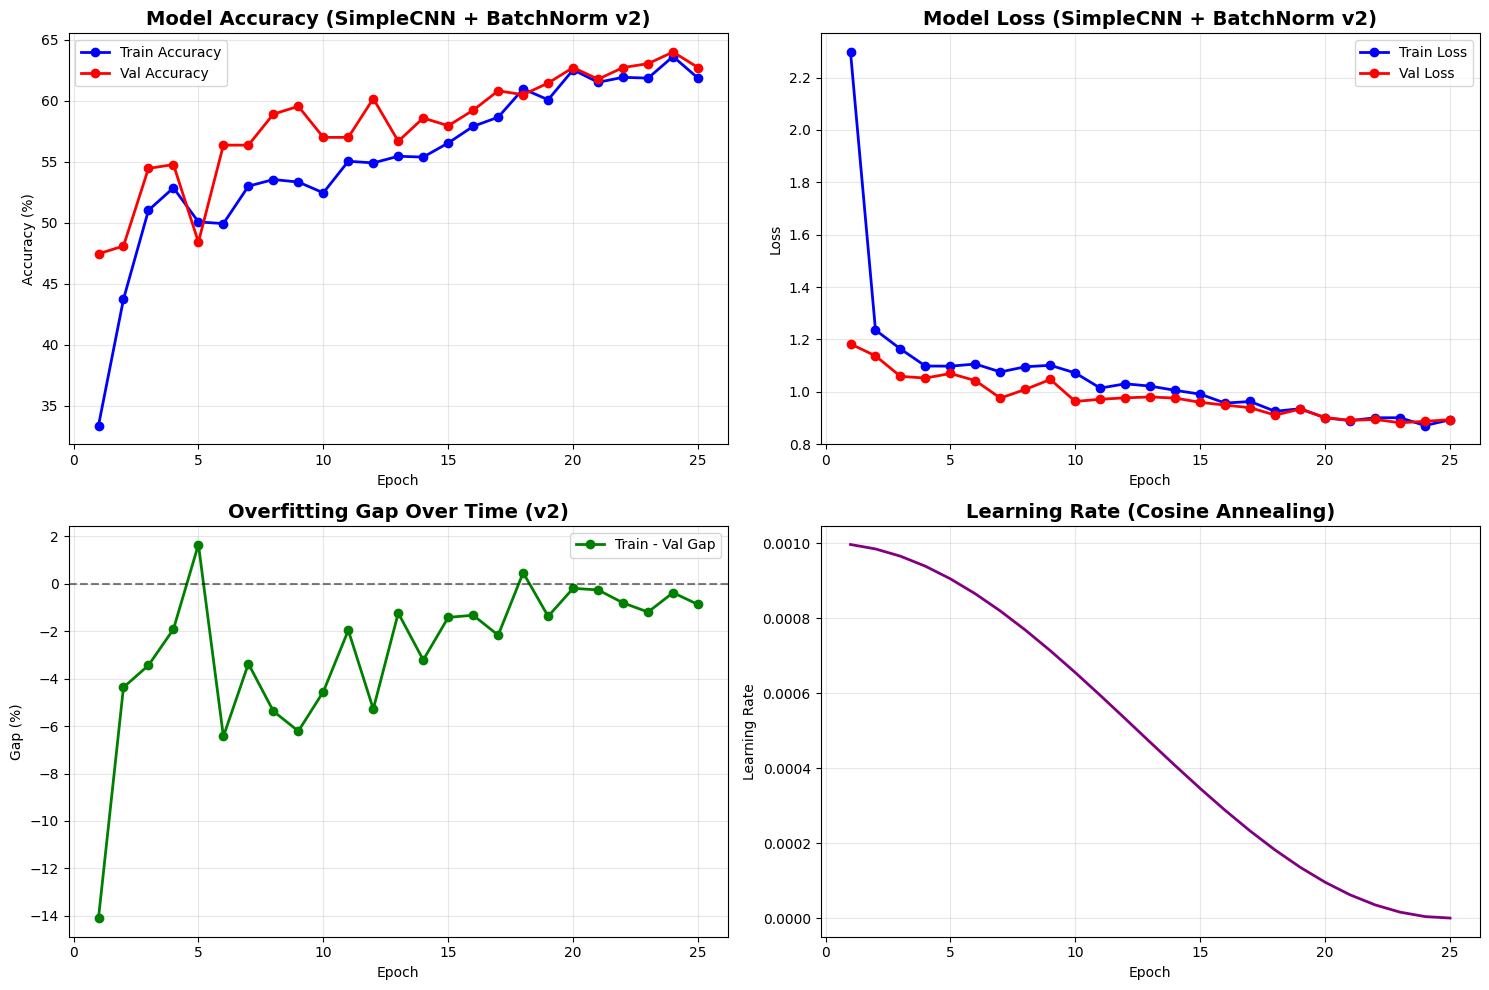

✅ Training plots v2 saved!
📊 Best Val Acc: 64.01%


In [18]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

epochs_range = range(1, len(history['train_acc']) + 1)

# Plot 1: Accuracy
axes[0, 0].plot(epochs_range, history['train_acc'], 'b-o', label='Train Accuracy', linewidth=2)
axes[0, 0].plot(epochs_range, history['val_acc'], 'r-o', label='Val Accuracy', linewidth=2)
axes[0, 0].set_title('Model Accuracy (SimpleCNN + BatchNorm v2)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Loss
axes[0, 1].plot(epochs_range, history['train_loss'], 'b-o', label='Train Loss', linewidth=2)
axes[0, 1].plot(epochs_range, history['val_loss'], 'r-o', label='Val Loss', linewidth=2)
axes[0, 1].set_title('Model Loss (SimpleCNN + BatchNorm v2)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Overfitting Gap
overfitting_gap = [train - val for train, val in zip(history['train_acc'], history['val_acc'])]
axes[1, 0].plot(epochs_range, overfitting_gap, 'g-o', label='Train - Val Gap', linewidth=2)
axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1, 0].set_title('Overfitting Gap Over Time (v2)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Gap (%)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Learning Rate
axes[1, 1].plot(epochs_range, history['lr'], 'purple', linewidth=2)
axes[1, 1].set_title('Learning Rate (Cosine Annealing)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(config.PLOTS_DIR / 'simple_cnn_batchnorm_training_v2.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Training plots v2 saved!")
print(f"📊 Best Val Acc: {best_val_acc:.2f}%")

## 🔟 סיכום וניתוח תוצאות

In [13]:
print("="*60)
print("📊 FINAL RESULTS - SimpleCNN + BatchNorm")
print("="*60)
print(f"\n🏆 Best Val Accuracy: {best_val_acc:.2f}%")
print(f"📈 Final Train Acc: {history['train_acc'][-1]:.2f}%")
print(f"📉 Final Val Acc: {history['val_acc'][-1]:.2f}%")
print(f"\n📊 Overfitting Analysis:")
print(f"   Gap: {results['overfitting_gap']:.2f}%")
if results['overfitting_gap'] < 2:
    print("   ✅ Excellent! Minimal overfitting.")
elif results['overfitting_gap'] < 5:
    print("   ✅ Good! Acceptable overfitting.")
else:
    print("   ⚠️  High overfitting. Consider more regularization.")

print(f"\n⏱️  Training Time: {results['training_time_minutes']:.1f} minutes")
print(f"📦 Model Size: {trainable_params:,} parameters")
print(f"\n💾 Best model saved to: {best_model_path}")
print(f"📄 Results saved to: {results_path}")
print("="*60)

📊 FINAL RESULTS - SimpleCNN + BatchNorm

🏆 Best Val Accuracy: 52.23%
📈 Final Train Acc: 40.04%
📉 Final Val Acc: 41.08%

📊 Overfitting Analysis:
   Gap: -1.04%
   ✅ Excellent! Minimal overfitting.

⏱️  Training Time: 7.9 minutes
📦 Model Size: 12,902,532 parameters

💾 Best model saved to: c:\Users\Administrator\Desktop\Dan\Projects\waste-classifier-fastai\final_project\results\models\simple_cnn_batchnorm_best.pth
📄 Results saved to: c:\Users\Administrator\Desktop\Dan\Projects\waste-classifier-fastai\final_project\results\logs\simple_cnn_batchnorm_results.json


## 🎯 השוואה: SimpleCNN vs SimpleCNN+BatchNorm

**השוואה תתבצע אחרי הריצה!** 🚀

נשווה:
- ✅ Validation Accuracy
- 📉 Overfitting Gap
- ⏱️ Training Time
- 🚀 Convergence Speed